In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr/

/home/remedios/kaisr/kaisr


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

from pathlib import Path
import nibabel as nib
import pprint as pp

from utils.plot import *
from utils.train_loader_1D_FB import TrainSet as TrainSet1D
from utils.train_loader_1D_FB import normalize
from utils.train_loader_patches import TrainSet as TrainSetPatches
from utils.filter_bank_utils import *
from utils.degrade import *
from tqdm import tqdm
import sympy
import symengine
from symengine import linsolve
def fourier_mag(x):
    return np.abs(np.fft.fftshift(np.fft.fft(x)))

set_display_mode('dark')
device = device = torch.device(f'cuda:1')

In [4]:
fwhm = 2
gap = 0
M = fwhm + gap
colors = plt.cm.rainbow(np.linspace(0, 1, M))

In [5]:
# lr_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
lr_fpath = Path(f"/home/remedios/data/old/OASIS3/OASIS3_{fwhm:02d}x_{gap:02d}gap_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=np.float32)

gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)

lr_vol = np.pad(lr_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

In [6]:
slice_profile_fpath = Path(f"../results/filters/{fwhm:02d}x_{gap:02d}gap_OAS30003/result.npy")

In [7]:
lr_vol.shape

(256, 256, 128)

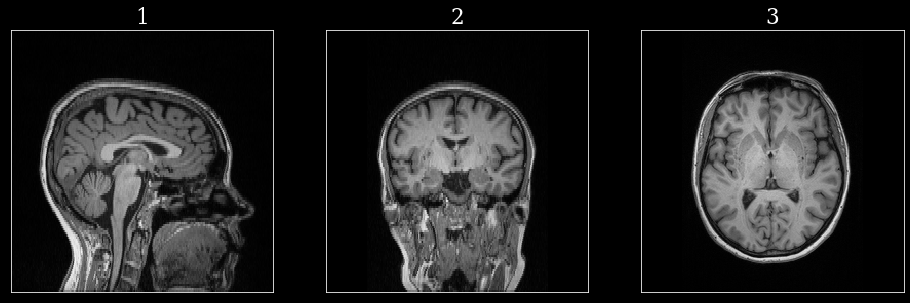

In [8]:
center_vol_plot(lr_vol, target_shape=(256, 256, 256))

In [9]:
def downsample_m(signal, M):
    return signal[::M]

In [10]:
def advance(signal, amt):
    if amt == 0:
        return signal
    return signal[amt:] + ['0'] * amt

In [11]:
def z_transform(x):
    return '+'.join([f'{h}*z^({-i})' for i, h in enumerate(x)])

In [12]:
def filters_to_polyphase(filters, m):
    return sympy.Matrix([
        [z_transform(downsample_m(advance(filt, i), m)) for i in range(m)]
        for filt in filters
    ])

In [13]:
def verify_PR(H_p, F_p, epsilon_precision=10):
    '''
    This should return an identity matrix
    '''
    
    A = sympy.simplify(H_p * F_p).xreplace(
        sympy.core.rules.Transform(
            lambda x: x.round(epsilon_precision), lambda x: isinstance(x, sympy.Float)
        )
    )
    B = sympy.eye(H_p.shape[0])
    return A == B

In [14]:
def sympy_round(x, epsilon=1e-12):
    return x.xreplace(dict([(n,0) for n in x.atoms(sympy.Float) if abs(n) < epsilon]))

In [15]:
def from_sympy(xs):
    return np.array([float(x) for x in xs]).astype(np.float32)

In [16]:
def plot_filters(hs, fs, freq=False):
    if type(hs[0]) != np.ndarray:
        hs = [h.detach().cpu().numpy() for h in hs]
        fs = [f.detach().cpu().numpy() for f in fs]

    for i, (h, color) in enumerate(zip(hs, colors)):
        if freq:
            plt.plot(fourier_mag(h), color=color, label=f'h_{i}')
        else:
            plt.plot(h, color=color, label=f'h_{i}')
    plt.grid()
    plt.legend()
    plt.show()

    for i, (f, color) in enumerate(zip(fs, colors)):
        if freq:
            plt.plot(fourier_mag(f), color=color, label=f'f_{i}')
        else:
            plt.plot(f, color=color, label=f'f_{i}')
    plt.grid()
    plt.legend()
    plt.show()

In [17]:
def inv_z_transform(H_p, type=1):
    '''
    Assume `H_p` is a `sympy.Matrix`,
    the polyphase representation
    '''
    
    if type == 1:
        mat = H_p
    elif type == 2:
        P = sympy.Matrix(np.rot90(np.eye(H_p.shape[0])).astype(np.uint32))
        print("Permuting for Type II...")
        mat = sympy.simplify(H_p.T * P / sympy.var('z'))
    else:
        raise ValueError("Invalid type:", type)
    
    z_vec = sympy.Matrix([f'z^{-i}' for i in range(mat.shape[0])])
    print("Substituting variables...")
    tmp = sympy.simplify(mat.subs('z', 'z^2') * z_vec)
    print("Finding coefficients...")
    
    if type == 1:
        return [sympy.Poly(t).coeffs()[::-1] for t in tmp]
    elif type == 2:
        return [sympy.Poly(t).coeffs() for t in tmp]

In [18]:
def solve_FIR(H_p, symbols, assert_flag=False):
    '''
    To get FIR filters, we need the determinant of H_p to be
    a single delay. This imposes constraints on the filters.
    
    We solve this symbolically with some tricks.
    '''
    z = sympy.var('z')
    # To find the z^-1 term, we first mulitply by z^-1 and recollect
    print("="*10, "Calculating determinant...", "="*10)
                
    H_p_det_z = (H_p.det() * z**(-1)).expand().collect(z)
    
    # then pick off the z^-2 term
    # All terms without z^-2 should equal 0
    # all terms with z^-2 should equal 1
    print("="*10, "Establishing conditions...", "="*10)
    zero_conds = [cond.subs('z', 1) for cond in H_p_det_z.args if not cond.has(z**(-2))]
    one_conds = [cond.subs('z', 1) + 1 for cond in H_p_det_z.args if cond.has(z**(-2))]
    
#     zero_conds = [cond.subs('z', 1) for cond in H_p_det_z.args if not cond.has(z**(-1))]
#     one_conds = [cond.subs('z', 1) - 1 for cond in H_p_det_z.args if cond.has(z**(-1))]

    # solve with constraints
    print("="*10, "Solving...", "="*10)
#     ans = sympy.solve([*zero_conds, *one_conds], symbols)
    
    # Using symengine's linsolve
    ans = linsolve([*zero_conds, *one_conds], symbols)
            
    if ans == []:
        raise Exception("No solutions found.")
    
    print("="*10, "Substituting terms...", "="*10)
    # Return the solution with variables substituted
#     result = H_p.subs([(str(k), str(v)) for k, v in ans.items()])
    # Subtitution is slightly different with symengine
    result = symengine.sympify(H_p).subs({k : v for k, v in zip(unknowns, ans)})
    
    if assert_flag:
        print("="*10, "Verifying PR...", "="*10)
        assert verify_PR(result, result.inv())
    print("="*10, "DONE", "="*10)
    return result

# Using symbolic library to invert the $\mathscr{H}_p$ matrix, imposing restrictions on remaining filters

In [19]:
sympy.init_printing(use_unicode=True)
symengine.init_printing()

In [20]:
np.set_printoptions(precision=3)

In [21]:
known_coefs = sympy.symbols(f'h:{5}')
h0 = list(known_coefs)

coefs = sympy.symbols(f'x:{len(h0)}')
unknowns = coefs[1:]
h1 = list(coefs)

In [22]:
H_p = filters_to_polyphase([h0, h1], 2)

In [23]:
H_p

⎡     h₂   h₄       h₃⎤
⎢h₀ + ── + ──  h₁ + ──⎥
⎢     z     2       z ⎥
⎢          z          ⎥
⎢                     ⎥
⎢     x₂   x₄       x₃⎥
⎢x₀ + ── + ──  x₁ + ──⎥
⎢     z     2       z ⎥
⎣          z          ⎦

In [24]:
H_p_solved = solve_FIR(H_p, symbols=unknowns)

========== Calculating determinant... ==========
========== Establishing conditions... ==========
========== Solving... ==========
========== Substituting terms... ==========
========== DONE ==========


In [25]:
# Using symengine to simplify and invert
H_p_solved.simplify()
H_p_inv_solved = H_p_solved.inv()

In [26]:
# Substitute h0
replace_syms = h0

slice_profile = np.load(slice_profile_fpath).astype(np.float64)
replace_vals = list(resize(
    slice_profile, 
    dxyz=(len(slice_profile) / len(h0),), 
    target_shape=(len(h0),),
))

subs = {k:v for k, v in zip(replace_syms, replace_vals)}
H_p_subbed = H_p_solved.subs(subs)
H_p_inv_subbed = H_p_inv_solved.subs(subs)

In [27]:
# Substitute
H_p_subbed = H_p_subbed.subs({coefs[0]: 1})
H_p_inv_subbed = H_p_inv_subbed.subs({coefs[0]: 1})

In [28]:
verify_PR(H_p_inv_subbed, H_p_subbed, epsilon_precision=0)

True

In [29]:
h0, h1 = inv_z_transform(H_p_subbed)

Substituting variables...
Finding coefficients...


In [30]:
f0, f1 = inv_z_transform(H_p_inv_subbed, type=2)

Permuting for Type II...
Substituting variables...
Finding coefficients...


In [31]:
print(f"h filter lengths: {len(h0)}, {len(h1)}")
print(f"f filter lengths: {len(f0)}, {len(f1)}")

h filter lengths: 5, 5
f filter lengths: 5, 5


In [32]:
f1

In [33]:
f0 = from_sympy(f0)
f1 = from_sympy(f1)
h0 = from_sympy(h0)
h1 = from_sympy(h1)

In [34]:
hs = [h0, h1]
fs = [f0, f1]

In [35]:
def epsilon_truncate(arr, epsilon):
    mask = arr> epsilon
    return arr[int(np.where(mask.any(axis=0), mask.argmax(axis=0), np.nan).item()):]

In [36]:
# epsilon = 1e-10
# # hs = [epsilon_truncate(h, epsilon) for h in hs]
# fs = [epsilon_truncate(f, epsilon) for f in fs]

In [37]:
# fs[1] = fs[1][:-1]

In [38]:
hs = [torch.from_numpy(h.copy()).to(device) for h in hs]
fs = [torch.from_numpy(f.copy()).to(device) for f in fs]

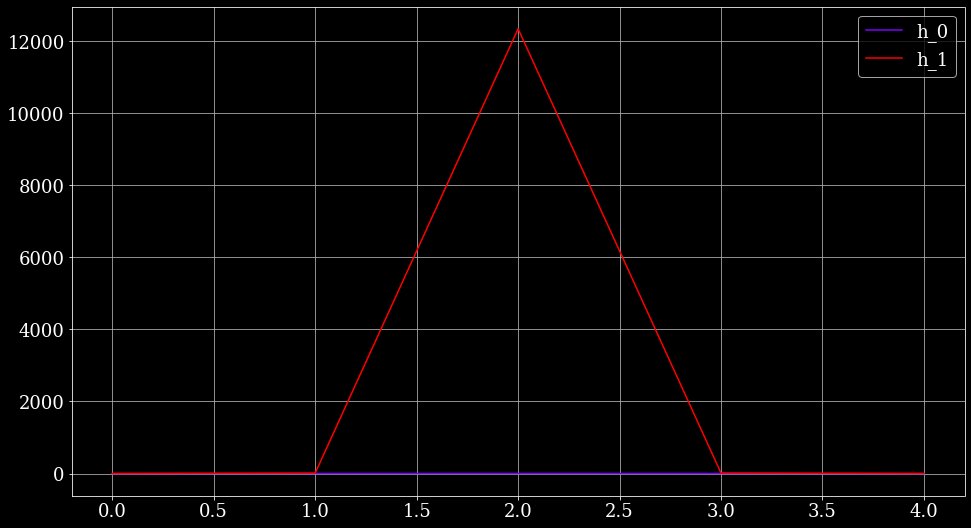

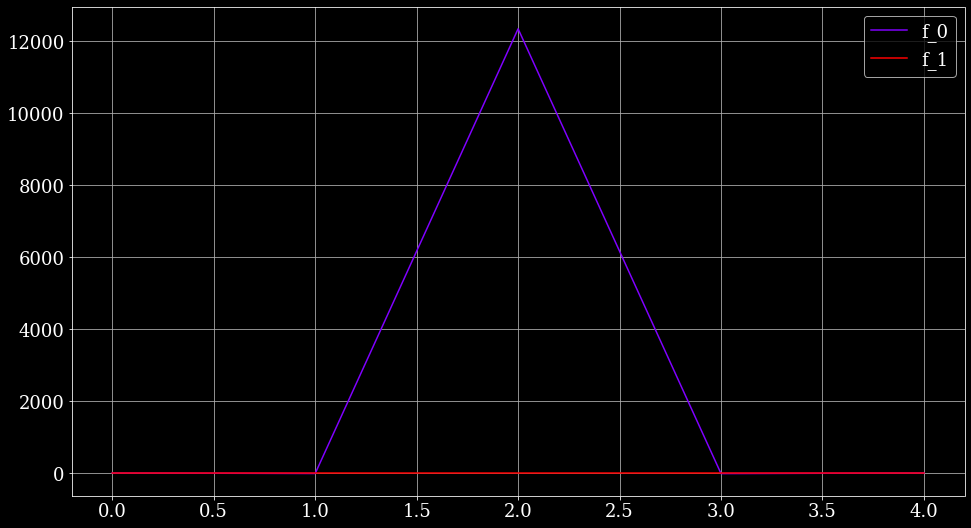

In [39]:
plot_filters(hs, fs, freq=False)

# Testing on a small $x$

In [40]:
# x = np.array(list(range(1, 101))).astype(np.float32)
# # x = np.pad(x, (0, 100))
# x = torch.from_numpy(x).unsqueeze(0).to(device)

x = torch.randn(41).unsqueeze(0).to(device)

# x = torch.from_numpy(np.array([1, 2, 3, 4, 5]).astype(np.float32)).unsqueeze(0).to(device)
# h_tmp = torch.from_numpy(np.array([1, 1, 1, 1, 1]).astype(np.float32)).to(device)

In [41]:
K_prime_0 = len(hs[0]) - 1
K_prime_1 = len(fs[0]) - 1

In [42]:
y0 = apply_filter(x, hs[0])
y1 = apply_filter(x, hs[1])

In [43]:
v0 = batch_downsample_m(y0, 2)
v1 = batch_downsample_m(y1, 2)

In [44]:
u0 = batch_upsample_m(v0, 2)
u1 = batch_upsample_m(v1, 2)

In [45]:
w0 = apply_filter(u0, fs[0])
w1 = apply_filter(u1, fs[1])

In [46]:
x_hat = w0 + w1

In [47]:
x.shape, x_hat.shape

(torch.Size([1, 41]), torch.Size([1, 50]))

In [48]:
x_hat = synthesize(analyze(x, hs), fs, divisibility_match=True)

In [49]:
x

tensor([[ 0.1169,  0.0750,  0.1437,  1.6587,  1.0113, -0.7298, -0.3077, -1.5371,
          0.3456, -0.8250,  1.1452,  0.7842,  0.8303,  0.0614,  0.2029, -2.1190,
          0.4047,  0.3475,  0.2430,  1.5660, -0.7292,  1.3153, -0.3115, -0.8043,
          2.6082, -0.4885, -1.3029,  0.3028, -0.9064, -1.1402,  0.2637,  0.3545,
         -1.6324,  0.7888, -0.9251,  0.6881,  0.1956, -1.0596,  0.2092,  0.1538,
         -2.7636]], device='cuda:1')

In [50]:
x_hat

tensor([[ 0.1165,  0.0740,  0.1434,  1.6573,  1.0117, -0.7290, -0.3079, -1.5364,
          0.3457, -0.8252,  1.1459,  0.7852,  0.8298,  0.0605,  0.2027, -2.1194,
          0.4056,  0.3469,  0.2430,  1.5663, -0.7290,  1.3149, -0.3111, -0.8047,
          2.6081, -0.4893, -1.3038,  0.3037, -0.9071, -1.1406,  0.2642,  0.3535,
         -1.6332,  0.7910, -0.9249,  0.6885,  0.1950, -1.0579,  0.2086,  0.1553,
         -2.7633]], device='cuda:1')

In [51]:
x_hat.shape

torch.Size([1, 41])

In [52]:
x.shape

torch.Size([1, 41])

In [53]:
torch.norm(x_hat - x, p=2)

tensor(0.0049, device='cuda:1')

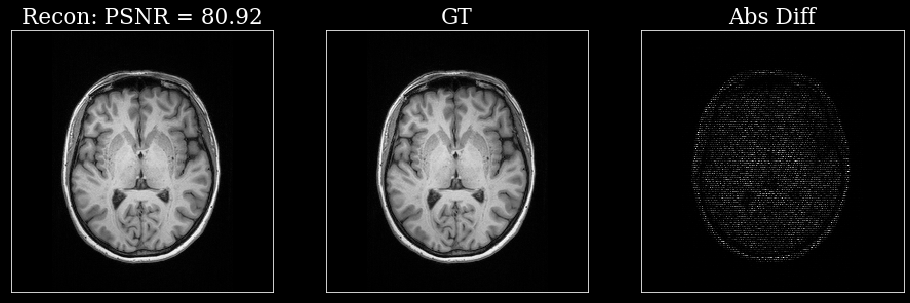

In [55]:
p = 32
x = lr_vol[:, :, lr_vol.shape[2]//2]
x = np.pad(x, ((0, 0), (p, p)))
x = torch.from_numpy(x).to(device)
x_hat = synthesize(analyze(x, hs=hs), fs=fs, divisibility_match=False)

x = x[:, p:-p]
x_hat = x_hat[:, p:-p]

x = x.detach().cpu().numpy()
x_hat = x_hat.detach().cpu().numpy()#[:, :-1]

diff = np.abs(x - x_hat)

data_range = x.max() - x.min()
psnr = peak_signal_noise_ratio(x, x_hat, data_range=data_range)

multiplot([x_hat, x, diff], [f'Recon: PSNR = {psnr:.2f}', 'GT', 'Abs Diff'])

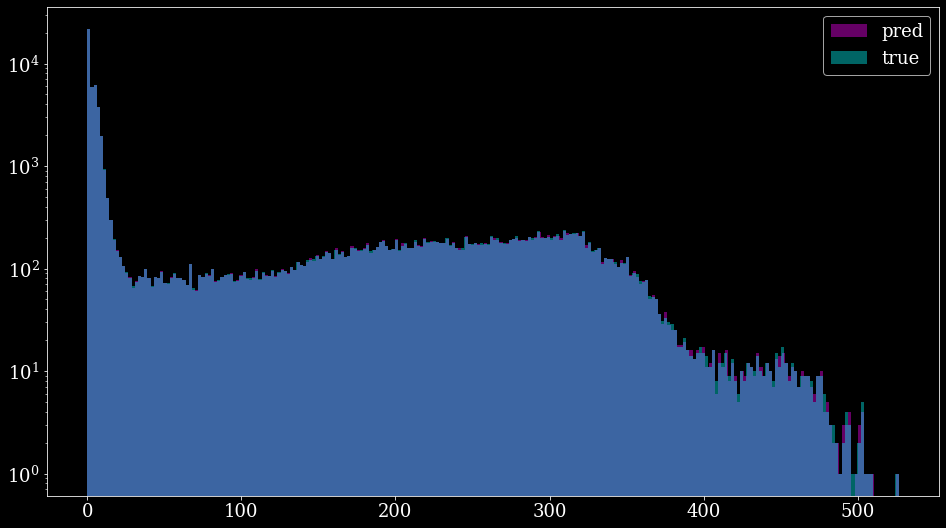

In [56]:
_ = plt.hist(x_hat.flatten(), bins=256, alpha=0.4, label='pred', color='magenta')
_ = plt.hist(x.flatten(),     bins=256, alpha=0.4, label='true', color='cyan')
plt.yscale('log')
plt.legend()
plt.show()

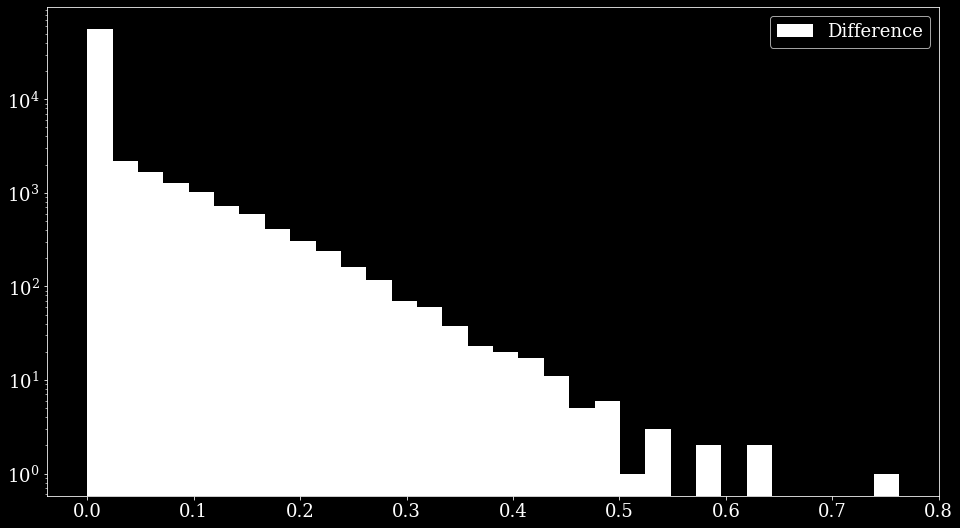

In [57]:
_ = plt.hist(diff.flatten(), bins=32, label='Difference')
plt.yscale('log')
plt.legend()
plt.show()

# TODO: Need to figure out how to make PR work with guaranteed PR filters. Something is either wrong in the implementation or the theory. Might be related to centering the filters in the time domain...